In [ ]:
# Imports

import tensorflow as tf
from keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [ ]:
# Loading and preprocessiung

def load_dogs_dataset(dataset_path, image_size=(64, 64), batch_size=32):
    dataset = tf.keras.utils.image_dataset_from_directory(
        dataset_path,
        image_size=image_size,
        batch_size=batch_size,
        color_mode='grayscale',
        label_mode=None 
    )
    dataset = dataset.map(lambda x: x / 255.0)
    return dataset

def generate_smaller_masks(shape):
    height, width, _ = shape 
    total_area = width * height
    target_mask_size = int(total_area * 0.25)
    mask = tf.zeros((height, width), dtype=tf.uint8)
    current_area = 0

    while current_area < target_mask_size:
        mask_width = np.random.randint(5, 20)
        mask_height = np.random.randint(5, 20)
        x = np.random.randint(0, width - mask_width)
        y = np.random.randint(0, height - mask_height)
        
        patch_area = mask_width * mask_height
        if current_area + patch_area > target_mask_size:
            patch_area = target_mask_size - current_area
            mask_width = int(np.sqrt(patch_area))
            mask_height = int(patch_area / mask_width)
        
        patch_indices = tf.reshape(
            tf.stack(tf.meshgrid(
                tf.range(y, y + mask_height),
                tf.range(x, x + mask_width),
                indexing='ij'
            ), axis=-1), (-1, 2)
        )
        
        mask = tf.tensor_scatter_nd_update(
            mask,
            patch_indices,
            tf.ones(patch_indices.shape[0], dtype=tf.uint8)
        )
        
        current_area += patch_area

    mask = tf.expand_dims(mask, axis=-1)  # shape should be (height, width, 1)
    return mask

def prepare_masked_dataset(dataset):
    def add_mask_and_target(images):
        shape = tf.shape(images)
        batch_size, height, width, channels = shape[0], shape[1], shape[2], shape[3]
        masks = tf.map_fn(
            lambda _: generate_smaller_masks((64, 64, 1)),
            tf.range(batch_size),
            dtype=tf.uint8
        )
        masks = tf.cast(masks, tf.float32)
        masks_inverted = 1 - masks 
        masked_images = images * masks_inverted
        return masked_images, images

    return dataset.map(add_mask_and_target)

def get_paired_datasets(images_path, masks_path, image_size=(64, 64), batch_size=32):
    image_files = sorted([f for f in os.listdir(images_path) if f.endswith('.jpg')])
    mask_files = sorted([f for f in os.listdir(masks_path) if f.endswith('.jpg')])

    # pairing of images and masks based on file names
    paired_files = [(os.path.join(images_path, img), os.path.join(masks_path, msk))
                    for img, msk in zip(image_files, mask_files) if os.path.basename(img) == os.path.basename(msk)]

    images = [tf.keras.preprocessing.image.load_img(img, color_mode='rgb', target_size=image_size) for img, _ in paired_files]
    masks = [tf.keras.preprocessing.image.load_img(msk, color_mode='grayscale', target_size=image_size) for _, msk in paired_files]

    # tensor conversion
    images = tf.convert_to_tensor([tf.keras.preprocessing.image.img_to_array(img) / 255.0 for img in images])
    masks = tf.convert_to_tensor([tf.keras.preprocessing.image.img_to_array(msk) / 255.0 for msk in masks])

    images_dataset = tf.data.Dataset.from_tensor_slices(images).batch(batch_size)
    masks_dataset = tf.data.Dataset.from_tensor_slices(masks).batch(batch_size)

    return images_dataset, masks_dataset

def prepare_masked_dataset_with_masks(images_dataset, masks_dataset):
    dataset = tf.data.Dataset.zip((images_dataset, masks_dataset))

    def process_mask(mask):
        binary_mask = tf.where(mask < 0.5, 0.0, 1.0)
        return binary_mask

    def add_mask_and_target(images, masks):
        binary_masks = process_mask(masks)
        masks_inverted = 1 - binary_masks
        masked_images = images * masks_inverted
        return masked_images, images

    return dataset.map(add_mask_and_target)

In [ ]:
# Plotting

def validation_plot(original_batch, masked_batch, reconstructed_batch):
    num_rows = 5
    num_cols = 8
    image_size = 128

    plt.figure(figsize=(num_cols * (image_size / 128), num_rows * (image_size / 128)))

    for i in range(num_rows):
        for j in range(2):
            idx = i * 2 + j

            # Original image
            plt.subplot(num_rows, num_cols, i * num_cols + j * 4 + 1)
            plt.imshow(np.array(original_batch[idx].numpy(), dtype=np.float32), aspect='auto')
            plt.axis('off')

            # Mask
            mask = masked_batch[idx].numpy() == 0
            plt.subplot(num_rows, num_cols, i * num_cols + j * 4 + 2)
            plt.imshow(mask.astype(np.float32), cmap='gray', aspect='auto')
            plt.axis('off')

            # Masked image
            plt.subplot(num_rows, num_cols, i * num_cols + j * 4 + 3)
            plt.imshow(masked_batch[idx].numpy(), cmap='gray', aspect='auto')
            plt.axis('off')

            # Reconstructed image
            reconstructed_image = np.where(mask, reconstructed_batch[idx], original_batch[idx].numpy())
            plt.subplot(num_rows, num_cols, i * num_cols + j * 4 + 4)
            plt.imshow(np.array(reconstructed_image, dtype=np.float32), aspect='auto')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# Architecture

def build_encoder(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    latent = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    return models.Model(inputs, latent, name='encoder')

def build_decoder(latent_shape):
    inputs = layers.Input(shape=latent_shape)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    outputs = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    return models.Model(inputs, outputs, name='decoder')

In [ ]:
# Paths and parameters

dataset_path = './dogs/200_dataset' # 200 images dataset

image_size = (64, 64)
batch_size = 32
input_shape = (*image_size, 1)

dataset = load_dogs_dataset(dataset_path, image_size=image_size, batch_size=batch_size)

train_dataset = dataset.take(500)
train_dataset = prepare_masked_dataset(train_dataset)

val_dataset = prepare_masked_dataset(dataset.skip(80).take(20))
train_targets = train_dataset

Found 589 files.
Instructions for updating:
Use fn_output_signature instead


In [5]:
# Model training

encoder = build_encoder(input_shape)
latent_shape = encoder.output_shape[1:]
decoder = build_decoder(latent_shape)

inputs = layers.Input(shape=input_shape)
latent = encoder(inputs)
outputs = decoder(latent)
autoencoder = models.Model(inputs, outputs, name='masked_autoencoder')
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(train_dataset, epochs=30)

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 875ms/step - loss: 0.0574
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 543ms/step - loss: 0.0250
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 592ms/step - loss: 0.0169
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 573ms/step - loss: 0.0125
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 589ms/step - loss: 0.0106
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 537ms/step - loss: 0.0090
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 571ms/step - loss: 0.0081
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 611ms/step - loss: 0.0077
Epoch 9/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 590ms/step - loss: 0.0072
Epoch 10/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 574ms/step - loss: 0.0068
Epoch 11/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 565ms/step - loss: 0.0071
Epoch 12/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 601ms/step - loss: 0.0073
Epoch 13/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 567ms/step - loss: 0.0062
Epoch 14/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 581ms/step - loss: 0.0059
Epoch 15/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


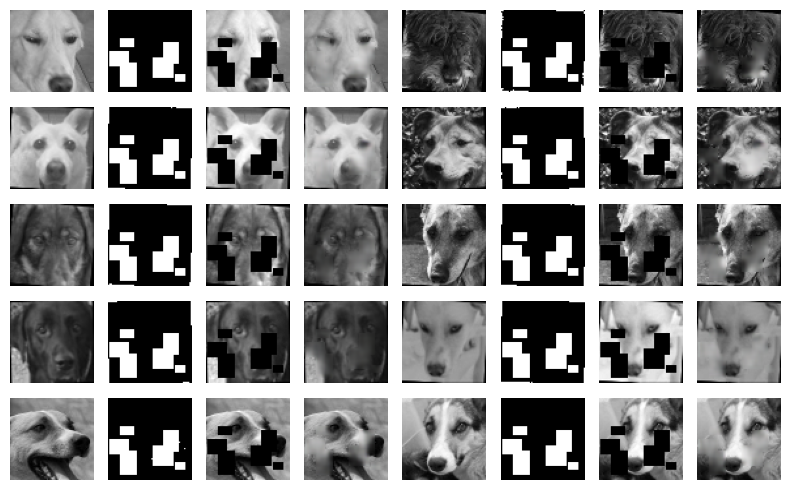

In [ ]:
# Validation of random samples with generated mask

sample_batch = next(iter(train_dataset))
masked_batch, original_batch = sample_batch
original_batch = tf.image.grayscale_to_rgb(original_batch)
reconstructed_batch = autoencoder.predict(masked_batch)

validation_plot(original_batch, masked_batch, reconstructed_batch)

Masked batch shape: (10, 64, 64, 3)
Original batch shape: (10, 64, 64, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


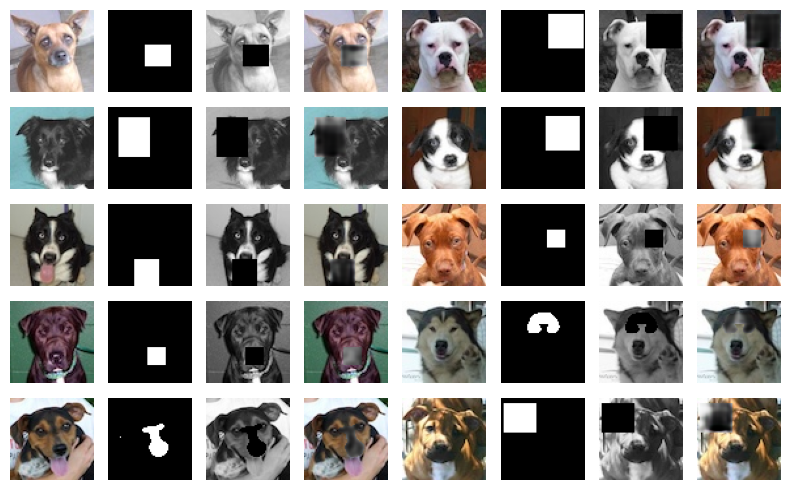

In [ ]:
# Validation of samples from validation dataset with validation masks

validation_images_path = "./dogs/custom_validation_dataset/images_dogs"
masks_path = "./dogs/custom_validation_dataset/masks_dogs"

validation_images_dataset, validation_masks_dataset = get_paired_datasets(
    validation_images_path, masks_path, image_size=image_size, batch_size=batch_size
)

validation_dataset = prepare_masked_dataset_with_masks(validation_images_dataset, validation_masks_dataset)

validation_dataset = validation_dataset.take(10)
validation_batch = next(iter(validation_dataset))
validation_masked_batch, validation_original_batch = validation_batch

# Debug
print("Masked batch shape:", validation_masked_batch.shape)
print("Original batch shape:", validation_original_batch.shape)

# Matching the number of channels to the expectations of the model
expected_channels = autoencoder.input_shape[-1]
if validation_masked_batch.shape[-1] != expected_channels:
    validation_masked_batch = tf.image.grayscale_to_rgb(validation_masked_batch) if expected_channels == 3 else tf.reduce_mean(validation_masked_batch, axis=-1, keepdims=True)

reconstructed_validation_batch = autoencoder.predict(validation_masked_batch)

validation_plot(validation_original_batch, validation_masked_batch, reconstructed_validation_batch)